In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#import warnings
#warnings.filterwarnings('ignore')

Загрузим датасет:

In [2]:
ds = pd.read_csv("winequality-red.csv")
ds.shape

(1599, 12)

In [3]:
ds.sample(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1187,7.0,0.430,0.30,2.0,0.085,6.0,39.0,0.99346,3.33,0.46,11.9,6
1122,6.3,0.470,0.00,1.4,0.055,27.0,33.0,0.99220,3.45,0.48,12.3,6
490,9.3,0.775,0.27,2.8,0.078,24.0,56.0,0.99840,3.31,0.67,10.6,6


Проверим датасет на целостность:

In [4]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
fixed acidity           1599 non-null float64
volatile acidity        1599 non-null float64
citric acid             1599 non-null float64
residual sugar          1599 non-null float64
chlorides               1599 non-null float64
free sulfur dioxide     1599 non-null float64
total sulfur dioxide    1599 non-null float64
density                 1599 non-null float64
pH                      1599 non-null float64
sulphates               1599 non-null float64
alcohol                 1599 non-null float64
quality                 1599 non-null int64
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


Определим, есть ли дубликаты:

In [5]:
ds[ds.duplicated()].shape[0]

240

Не будем удалять дубликаты, полагая, что это оценки одного и того же вина разными дегустаторами.

In [6]:
#ds.drop_duplicates(inplace=True)

Проведем анализ имеющихся данных. Посмотрим на распределение признаков:

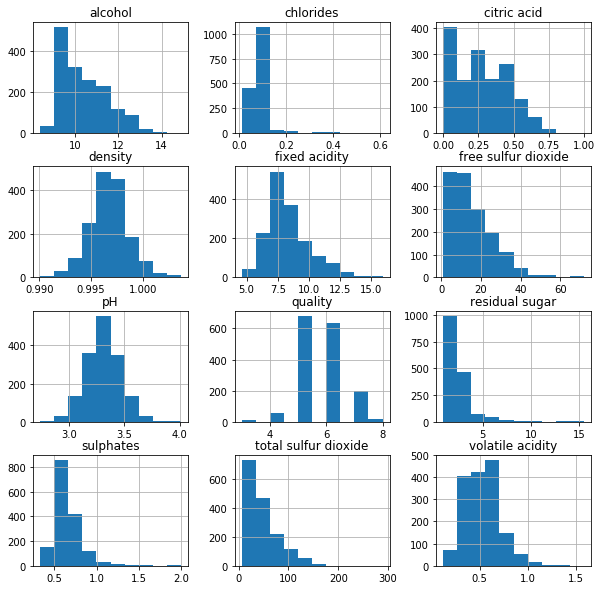

In [7]:
ds.hist(figsize=(10,10))
plt.show()

Построим корреляционную матрицу:

In [8]:
import seaborn as sns

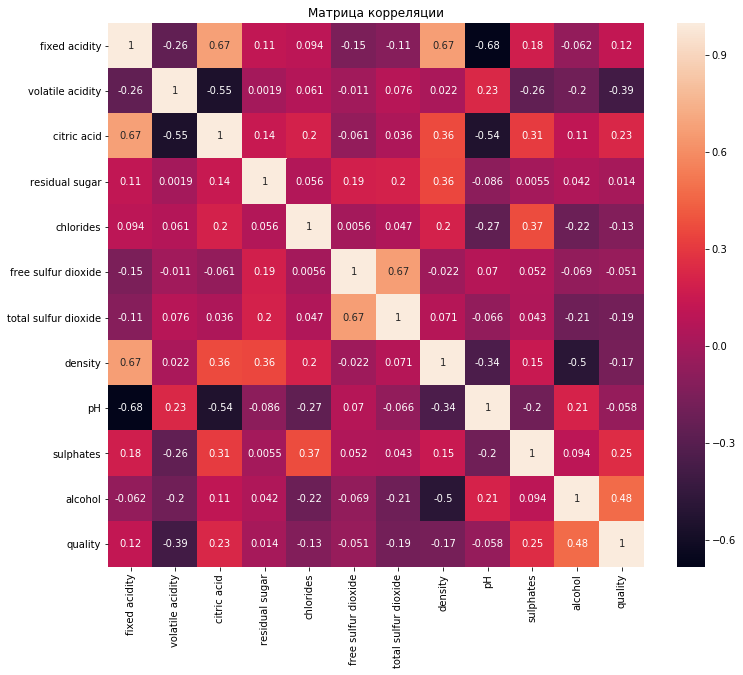

In [9]:
corr = ds.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True)
plt.title('Матрица корреляции');

Видим, что % алкоголя, сульфаты и лимонная кислота оказывают наибольшее влияние на качество.

Так как в задаче не указана целевая метрика, то будем рассматривать задачу регрессии с метрикой MSE.

Разделим датасет на тестовую и обучающую выборки:

In [10]:
RANDOM_SEED = 593

In [11]:
from sklearn.model_selection import train_test_split

X = ds.drop('quality', axis=1)
y = ds['quality']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

Стандартизируем данные:

In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [13]:
from sklearn.linear_model import SGDRegressor, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

In [14]:
models = {"Linear": LinearRegression(),
         "SGD": SGDRegressor(tol=1e-3, random_state=0),
         "DT": DecisionTreeRegressor(random_state=RANDOM_SEED),
         "RF": RandomForestRegressor(n_estimators=100, random_state=RANDOM_SEED),
         "XGBoost": XGBRegressor(n_estimators=100, random_state=RANDOM_SEED)}

In [15]:
from sklearn.metrics import mean_squared_error

for model in models:
    clf = models[model]
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print ("%s: %s " %(model, mean_squared_error(y_test, y_pred)))

Linear: 0.4012413583832797 
SGD: 0.40446297012069293 
DT: 0.76875 
RF: 0.3337971875 
XGBoost: 0.3724230968558537 


Возьмем лучшие алгоритмы (Random Forest, XGBoost) и подберем гиперпараметры:

In [16]:
rf_params = {
    'n_estimators': np.arange(20, 220, 20),
    'max_depth': np.arange(10, 60, 10),
    'max_features': [None, 0.5]
}

xgb_params = {
    'learning_rate': np.arange(0.03, 0.3, 0.03),
    'n_estimators': np.arange(20, 210, 10)
}

In [17]:
from sklearn.model_selection import GridSearchCV

rf_regr = RandomForestRegressor(random_state=RANDOM_SEED)
xgb_regr = XGBRegressor(random_state=RANDOM_SEED)

rf_gs = GridSearchCV(rf_regr, param_grid=rf_params, scoring='neg_mean_squared_error', cv=5, refit=True, n_jobs=4)
xgb_gs = GridSearchCV(xgb_regr, param_grid=xgb_params, scoring='neg_mean_squared_error', cv=5, refit=True, n_jobs=4)

In [18]:
%%time
rf_gs.fit(X_train, y_train)
xgb_gs.fit(X_train, y_train)

Wall time: 2min 51s


In [19]:
y_pred_rf = rf_gs.best_estimator_.predict(X_test)
y_pred_xgb = xgb_gs.best_estimator_.predict(X_test)
print("RF: %s" % mean_squared_error(y_test, y_pred_rf))
print("XGB: %s" % mean_squared_error(y_test, y_pred_xgb))

RF: 0.3195940695418719
XGB: 0.38031812345627714


Таким образом, удалось уменьшить среднеквадратичную ошибку до 0,32. Сохраним предсказания лучшей модели в файл:

In [20]:
X_scaled = scaler.transform(X)
y_best = rf_gs.best_estimator_.predict(X_scaled)
pd.DataFrame(y_best).to_csv('predictions.csv', index=None, header=None)